# Simulating and fitting data using a simple Stick model

As in the previous tutorial we will use the wu-minn acquisition scheme to do our experiments. Instead of loading it from scratch, we load it from dmipy.data.saved_acquisition_schemes, which contains some saved dmipy acquisition schemes.

In [1]:
# load the necessary modules
from dmipy.signal_models import cylinder_models
from dmipy.core import modeling_framework
from dmipy.data import saved_acquisition_schemes
import numpy as np

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

Using this acquisition scheme, we will simulate data using a simple Stick model, and then use the same Stick model to fit the signal again. First, we instantiate the model(s) we need.

NOTE: this example the same for any other dmipy model. One only needs to change the model and appropriate input parameters.

In [2]:
stick = cylinder_models.C1Stick()

In dmipy, all the simulation and fitting functionality is contained in the MultiCompartmentModel module. To simulate some data, we therefore make a MultiCompartmentModel that just contains the Stick model.

In [3]:
from dmipy.core.modeling_framework import MultiCompartmentModel
stick_model = MultiCompartmentModel(models=[stick])

We can visualize the flow diagram of the model using the `visualize_model_setup` command:

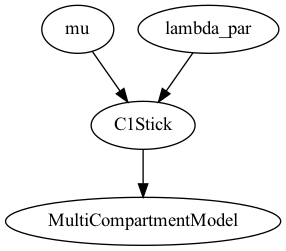

In [4]:
from IPython.display import Image
stick_model.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')

To find more information on the model parameters check the function documentation of the Stick model. It is also possible to print the parameter cardinality to figure out the parameter names, and their input format.

In [5]:
stick_model.parameter_cardinality

OrderedDict([('C1Stick_1_mu', 2), ('C1Stick_1_lambda_par', 1)])

First thing to notice is name of the model "C1Stick" and the parameter "mu" is separated by a number "\_1\_". If multiple sticks are given to the MultiCompartmentModel, then this number will increase as more Sticks are added.


The number after the parameter name indicates the cardinality of the parameter, meaning that the orientation of the stick "mu" takes two angles on the sphere as [theta, phi], and one value as parallel diffusivity lambda_par.

For the example we align the Stick with some angle and give it a diffusivity of 1.7e-9 m^2/s. We obtain the right ordering for the input of the function by using the model's parameters_to_parameter_vector() function:

In [6]:
mu = (np.pi / 2., np.pi / 2.)  # in radians
lambda_par = 1.7e-9  # in m^2/s
parameter_vector = stick_model.parameters_to_parameter_vector(
    C1Stick_1_lambda_par=lambda_par, C1Stick_1_mu=mu)

As you can see, this produces a parameter vector with the 'correct' order for the model to understand it.

In [7]:
parameter_vector

array([1.57079633e+00, 1.57079633e+00, 1.70000000e-09])

We can generate the diffusion-weighted signals for these model parameters and the wu-minn acquisition scheme as follows:

In [8]:
E = stick_model.simulate_signal(acq_scheme, parameter_vector)
len(E)  # See that this produces the signal attenuation for the entire acquisition scheme

288

In [10]:
acq_scheme

Let's assume this signal is now unknown, and we want to fit the Stick model to this signal to find best fitting model parameters. the model.fit(scheme, data) is the easiest way to fit some data. As a default, dmipy uses a global optimizer that we call brute2fine, which does exactly what the name implies: first to a global brute-force optimization and then refine solution to a local minimum.

In [9]:
res = stick_model.fit(acq_scheme, E)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.0109260082245 seconds
Fitting of 1 voxels complete in 0.267587184906 seconds.
Average of 0.267587184906 seconds per voxel.


Using the data and the acquisition scheme we fit the stick_model using the following one-liner. We can see the correct model parameters are obtained.

In [10]:
print 'Optimized result:', res.fitted_parameters_vector
print 'Ground truth:    ', parameter_vector

Optimized result: [[ 1.57080726e+00 -1.57079593e+00  1.70010076e-09]]
Ground truth:     [1.57079633e+00 1.57079633e+00 1.70000000e-09]
